In [ ]:
import pandas as pd
import numpy as np

# --- 1. Configuration & Setup ---
num_records = 25000
file_name = "synthetic_credit_score_dataset.csv"

# Set a random seed for reproducibility
np.random.seed(42)

print(f"Generating {num_records} realistic customer credit records...")

# --- 2. Step-by-Step Feature Generation ---

# A. Foundational Demographics (Mostly Independent)
customer_ids = np.arange(1, num_records + 1)
age = np.random.normal(loc=40, scale=12, size=num_records).astype(int)
age = np.clip(age, 18, 85)

gender_choices = ['Male', 'Female', 'Other']
gender_probs = [0.49, 0.49, 0.02]
genders = np.random.choice(gender_choices, size=num_records, p=gender_probs)

location_choices = ['Metro', 'Urban', 'Rural']
location_probs = [0.4, 0.35, 0.25]
locations = np.random.choice(location_choices, size=num_records, p=location_probs)

# B. The Financial Anchor: Income (Log-Normal Distribution)
income_log_mean = np.log(6000) # Median income around $6k/month
income_log_std = 0.7
monthly_income = np.random.lognormal(mean=income_log_mean, sigma=income_log_std, size=num_records)
# Add location-based income adjustments (Correlation)
location_income_adjust = {'Metro': 1.2, 'Urban': 1.0, 'Rural': 0.85}
income_adjustment = np.array([location_income_adjust[loc] for loc in locations])
monthly_income = (monthly_income * income_adjustment).round(2)

# C. Independent Behavioral Events (Poisson for Counts)
# These are the raw materials for risk assessment
dpd_last_3_months = np.random.poisson(lam=0.15, size=num_records) # DPDs are rare
num_hard_inquiries_last_6m = np.random.poisson(lam=1.2, size=num_records)
num_open_loans = np.random.poisson(lam=2.5, size=num_records)
num_open_loans = np.clip(num_open_loans, 0, 15) # Cap at a reasonable number

# D. Lender-Side Features (Correlated with Income & Risk)
# total_credit_limit is heavily correlated with income but also influenced by risk
income_multiplier = np.random.uniform(2.5, 6, size=num_records)
# Penalty for recent DPDs
dpd_limit_penalty = dpd_last_3_months * np.random.uniform(500, 1500, size=num_records)
total_credit_limit = (monthly_income * income_multiplier) - dpd_limit_penalty
total_credit_limit = np.clip(total_credit_limit, 500, 250000).round(2) # Min/Max limits

# E. Customer-Side Debt & Utilization (The Core of Financial Health)
# We'll generate a base utilization and penalize it for risky behavior
# Beta distribution is great for values between 0 and 1
base_utilization = np.random.beta(a=2, b=5, size=num_records)
# Add penalties for risk factors (Correlation)
dpd_util_penalty = dpd_last_3_months * np.random.uniform(0.05, 0.1)
inquiry_util_penalty = num_hard_inquiries_last_6m * np.random.uniform(0.01, 0.03)
credit_utilization_ratio = base_utilization + dpd_util_penalty + inquiry_util_penalty
credit_utilization_ratio = np.clip(credit_utilization_ratio, 0.01, 1.0).round(3)

# Now, calculate current_outstanding and monthly_emi_outflow based on the above
current_outstanding = (total_credit_limit * credit_utilization_ratio).round(2)
# EMI is a fraction of outstanding debt + a fraction of income for other loans
emi_debt_fraction = np.random.uniform(0.03, 0.08, size=num_records)
emi_income_fraction = num_open_loans * np.random.uniform(0.01, 0.03, size=num_records)
monthly_emi_outflow = (current_outstanding * emi_debt_fraction) + (monthly_income * emi_income_fraction)
monthly_emi_outflow = np.clip(monthly_emi_outflow, 0, monthly_income * 0.8).round(2) # Cap EMI at 80% of income

# F. Creating the Summary & Sparse Features
# repayment_history_score is a direct summary of behavior
base_score = 100
dpd_score_penalty = dpd_last_3_months * 15
util_score_penalty = (credit_utilization_ratio > 0.7) * 10
inquiry_score_penalty = num_hard_inquiries_last_6m * 2
repayment_history_score = base_score - dpd_score_penalty - util_score_penalty - inquiry_score_penalty
repayment_history_score = np.clip(repayment_history_score, 0, 100).astype(int)

# recent_credit_card_usage: change in balance
# Responsible users (high score) tend to pay down, risky users (low score) tend to spend
usage_tendency = (80 - repayment_history_score) / 100 # -0.2 to 0.8
usage_magnitude = current_outstanding * np.random.uniform(0.05, 0.2)
recent_credit_card_usage = (usage_tendency * usage_magnitude).round(2)

# recent_loan_disbursed_amount: Sparse feature
loan_disbursed_mask = (num_hard_inquiries_last_6m > 0) & (np.random.rand(num_records) < 0.25) # 25% chance if inquiry
loan_amounts = monthly_income * np.random.uniform(1, 4, size=num_records)
recent_loan_disbursed_amount = np.where(loan_disbursed_mask, loan_amounts, 0).round(2)

# months_since_last_default: Sparse feature with NaNs
has_defaulted_mask = np.random.rand(num_records) < 0.05 # 5% of population has defaulted before
default_months = np.random.randint(6, 72, size=num_records)
months_since_last_default = np.where(has_defaulted_mask, default_months, np.nan)


# --- 3. The Target Variable: Probabilistic Heuristics ---
# Create a hidden "financial_health_trend" score to determine the target
health_score = np.zeros(num_records)

# Positive factors
health_score += (repayment_history_score - 75) * 0.1 # Good score helps
health_score -= (credit_utilization_ratio - 0.4) * 5 # High utilization hurts
health_score -= (monthly_emi_outflow / monthly_income - 0.3) * 3 # High debt-to-income ratio hurts
health_score -= recent_credit_card_usage * 0.001 # Increasing balance hurts

# Negative event penalties
health_score -= dpd_last_3_months * 5 # DPDs are very bad
health_score -= num_hard_inquiries_last_6m * 1.5 # Inquiries are a moderate risk
health_score -= (recent_loan_disbursed_amount > 0) * 3 # A new loan is a short-term risk

# Add final random noise to simulate uncaptured factors
health_score += np.random.normal(0, 2.5, size=num_records)

# Use quantiles of the health score to assign the target label
decrease_threshold = np.quantile(health_score, 0.30) # Bottom 30%
increase_threshold = np.quantile(health_score, 0.70) # Top 30%

target_conditions = [
    health_score < decrease_threshold,
    health_score >= increase_threshold
]
target_choices = ['decrease', 'increase']
target_credit_score_movement = np.select(target_conditions, target_choices, default='stable')


# --- 4. Assemble and Save the Dataset ---
data = {
    'customer_id': customer_ids,
    'age': age,
    'gender': genders,
    'location': locations,
    'monthly_income': monthly_income,
    'monthly_emi_outflow': monthly_emi_outflow,
    'total_credit_limit': total_credit_limit,
    'current_outstanding': current_outstanding,
    'credit_utilization_ratio': credit_utilization_ratio,
    'num_open_loans': num_open_loans,
    'repayment_history_score': repayment_history_score,
    'dpd_last_3_months': dpd_last_3_months,
    'num_hard_inquiries_last_6m': num_hard_inquiries_last_6m,
    'recent_credit_card_usage': recent_credit_card_usage,
    'recent_loan_disbursed_amount': recent_loan_disbursed_amount,
    'months_since_last_default': months_since_last_default,
    'target_credit_score_movement': target_credit_score_movement
}

df = pd.DataFrame(data)

# Save the dataset to a CSV file
df.to_csv(file_name, index=False)

print(f"\nDataset successfully generated and saved as '{file_name}'")
print("\n--- Dataset Preview ---")
print(df.head())
print("\n--- Dataset Info ---")
df.info()
print("\n--- Dataset Statistics ---")
print(df.describe())
print("\n--- Target Variable Distribution ---")
print(df['target_credit_score_movement'].value_counts(normalize=True))

Generating 25000 realistic customer credit records...

Dataset successfully generated and saved as 'synthetic_credit_score_dataset.csv'

--- Dataset Preview ---
   customer_id  age  gender location  monthly_income  monthly_emi_outflow  \
0            1   45  Female    Rural         7323.55              1275.56   
1            2   38   Other    Rural         7896.63               598.12   
2            3   47    Male    Urban        17907.45              2830.84   
3            4   58  Female    Metro        13781.08              2477.50   
4            5   37  Female    Metro         1793.36               204.46   

   total_credit_limit  current_outstanding  credit_utilization_ratio  \
0            37196.92             14655.59                     0.394   
1            36648.28              4947.52                     0.135   
2           104893.68             34510.02                     0.329   
3            81640.55             32329.66                     0.396   
4             55

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some visual styles for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Load the dataset
try:
    df = pd.read_csv('synthetic_credit_score_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'synthetic_credit_score_dataset.csv' not found.")
    print("Please make sure you have run the data generation script from Step 1.")
    # Exit or handle the error appropriately
    exit()


Dataset loaded successfully!


In [ ]:
print("--- Dataset Info ---")
df.info()

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   25000 non-null  int64  
 1   age                           25000 non-null  int64  
 2   gender                        25000 non-null  object 
 3   location                      25000 non-null  object 
 4   monthly_income                25000 non-null  float64
 5   monthly_emi_outflow           25000 non-null  float64
 6   total_credit_limit            25000 non-null  float64
 7   current_outstanding           25000 non-null  float64
 8   credit_utilization_ratio      25000 non-null  float64
 9   num_open_loans                25000 non-null  int64  
 10  repayment_history_score       25000 non-null  int64  
 11  dpd_last_3_months             25000 non-null  int64  
 12  num_hard_inquiries_last_6m    25000 non

In [ ]:
print("\n--- Numerical Feature Statistics ---")
print(df.describe())


--- Numerical Feature Statistics ---
        customer_id           age  monthly_income  monthly_emi_outflow  \
count  25000.000000  25000.000000    25000.000000         25000.000000   
mean   12500.500000     39.691640     7983.199675          1008.139867   
std     7217.022701     11.594165     6458.189035          1028.321734   
min        1.000000     18.000000      224.290000             6.420000   
25%     6250.750000     31.000000     3849.842500           385.760000   
50%    12500.500000     40.000000     6194.885000           698.940000   
75%    18750.250000     48.000000     9975.872500          1258.497500   
max    25000.000000     85.000000   105101.710000         16423.560000   

       total_credit_limit  current_outstanding  credit_utilization_ratio  \
count        25000.000000          25000.00000              25000.000000   
mean         33674.263087          10975.74023                  0.325802   
std          28605.905445          11888.20885                  0.1

In [ ]:
print("\n--- Target Variable Distribution ---")
print(df['target_credit_score_movement'].value_counts())

print("\n--- Location Distribution ---")
print(df['location'].value_counts(normalize=True)) # normalize=True shows percentages


--- Target Variable Distribution ---
target_credit_score_movement
stable      10000
decrease     7500
increase     7500
Name: count, dtype: int64

--- Location Distribution ---
location
Metro    0.39656
Urban    0.35248
Rural    0.25096
Name: proportion, dtype: float64


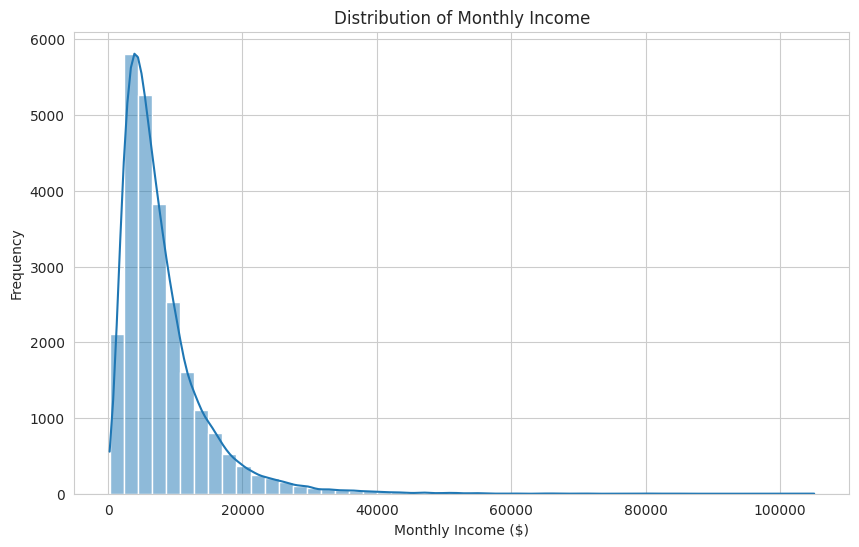

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['monthly_income'], bins=50, kde=True)
plt.title('Distribution of Monthly Income')
plt.xlabel('Monthly Income ($)')
plt.ylabel('Frequency')
plt.show()

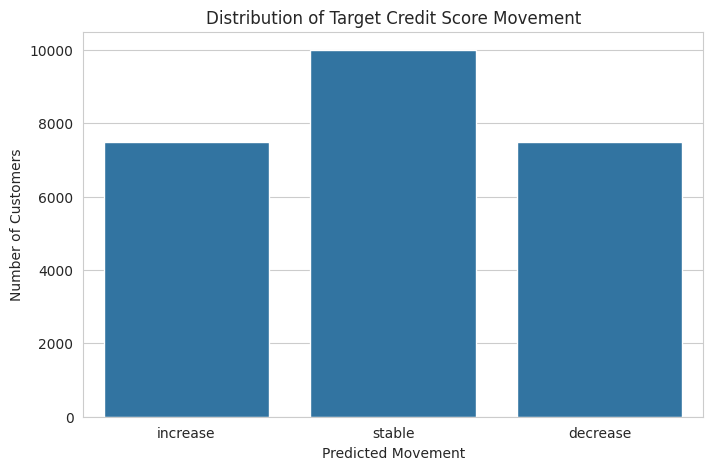

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target_credit_score_movement', data=df, order=['increase', 'stable', 'decrease'])
plt.title('Distribution of Target Credit Score Movement')
plt.xlabel('Predicted Movement')
plt.ylabel('Number of Customers')
plt.show()

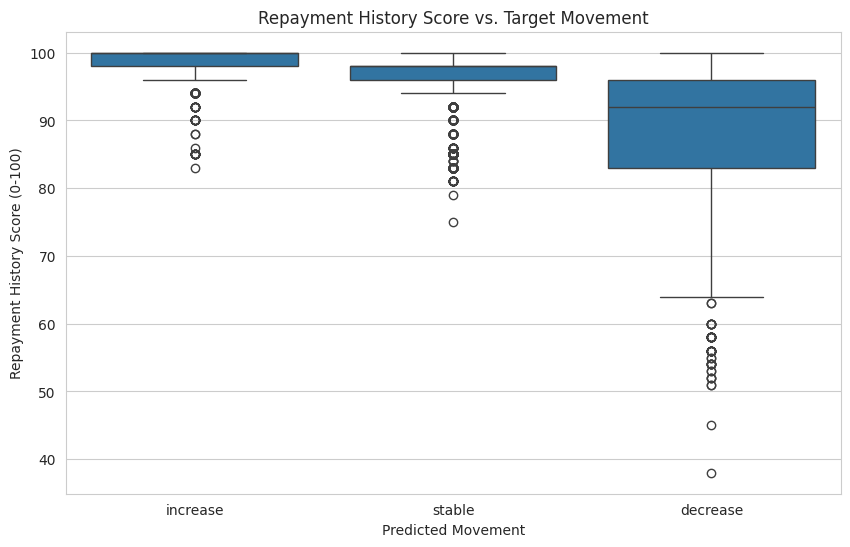

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target_credit_score_movement', y='repayment_history_score', data=df, order=['increase', 'stable', 'decrease'])
plt.title('Repayment History Score vs. Target Movement')
plt.xlabel('Predicted Movement')
plt.ylabel('Repayment History Score (0-100)')
plt.show()

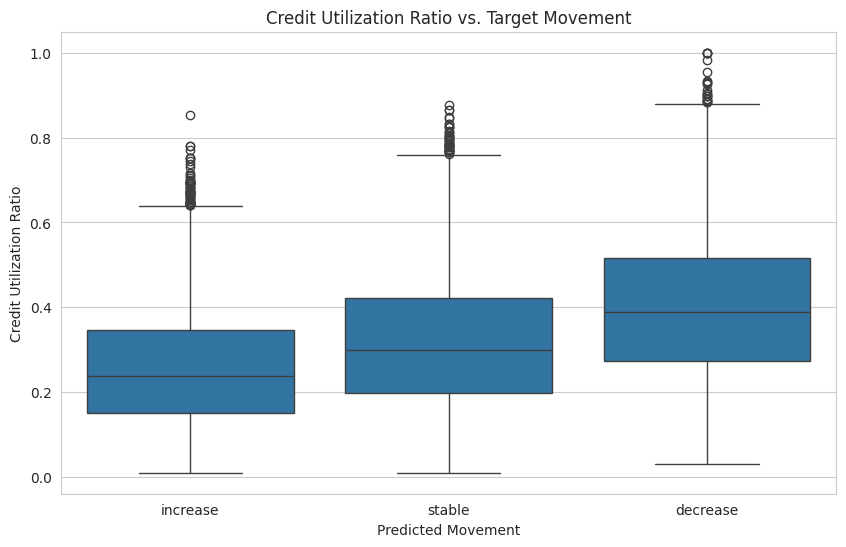

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target_credit_score_movement', y='credit_utilization_ratio', data=df, order=['increase', 'stable', 'decrease'])
plt.title('Credit Utilization Ratio vs. Target Movement')
plt.xlabel('Predicted Movement')
plt.ylabel('Credit Utilization Ratio')
plt.show()

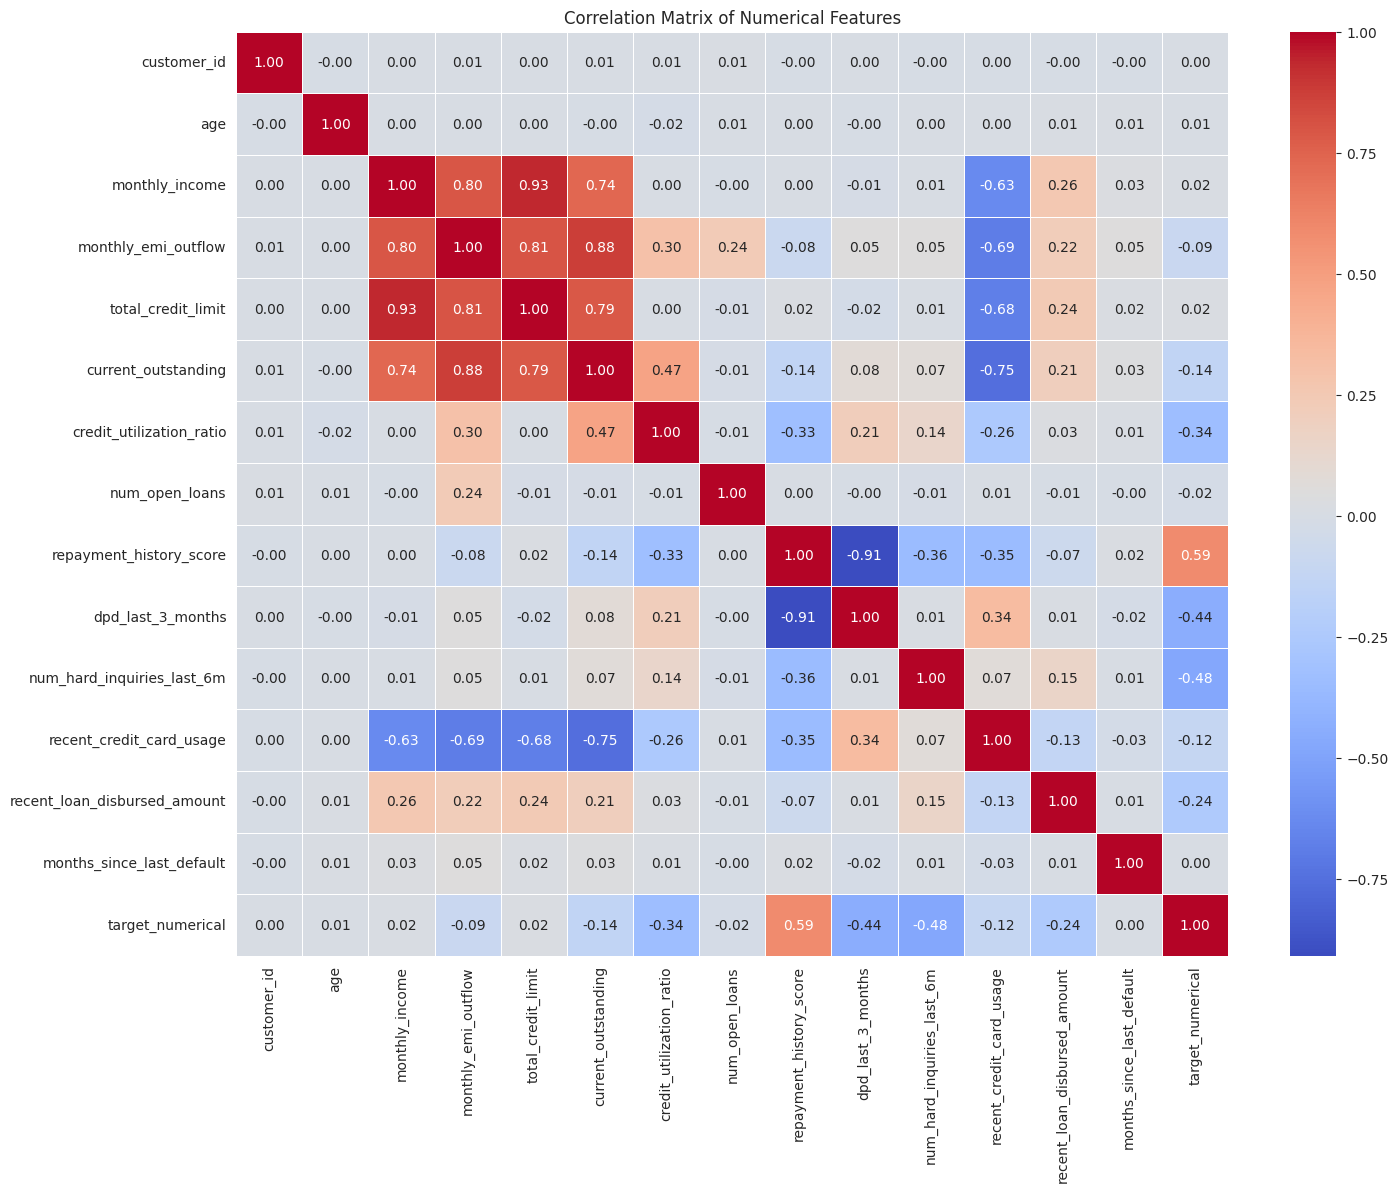

In [ ]:
# Create a copy for analysis to not mess up the original dataframe
df_corr = df.copy()

# Map the target to numerical values for correlation analysis
target_mapping = {'decrease': -1, 'stable': 0, 'increase': 1}
df_corr['target_numerical'] = df_corr['target_credit_score_movement'].map(target_mapping)

# Calculate the correlation matrix
# We must select only numeric columns for this
numeric_cols = df_corr.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# MODEL TRAINING

In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Scikit-learn for Preprocessing and Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Imbalanced-learn for Handling Class Imbalance ---
# You might need to install this in Colab: !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use this pipeline to include SMOTE

# --- The Model ---
import xgboost as xgb

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('synthetic_credit_score_dataset.csv')

print("Libraries imported and dataset loaded.")
df.head()

Libraries imported and dataset loaded.


,customer_id,age,gender,location,monthly_income,monthly_emi_outflow,total_credit_limit,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,months_since_last_default,target_credit_score_movement
0,1,45,Female,Rural,7323.55,1275.56,37196.92,14655.59,0.394,2,90,0,5,-90.78,25382.41,51.0,decrease
1,2,38,Other,Rural,7896.63,598.12,36648.28,4947.52,0.135,2,100,0,0,-61.29,0.00,30.0,increase
2,3,47,Male,Urban,17907.45,2830.84,104893.68,34510.02,0.329,4,96,0,2,-342.00,0.00,16.0,increase
3,4,58,Female,Metro,13781.08,2477.50,81640.55,32329.66,0.396,3,98,0,1,-360.45,0.00,NaN,stable
4,5,37,Female,Metro,1793.36,204.46,5550.47,1443.12,0.260,6,100,0,0,-17.88,0.00,NaN,increase


In [ ]:
# The target variable is what we want to predict.
y = df['target_credit_score_movement']

# The features are all the columns we will use to make the prediction.
# We drop the target and any identifier columns that provide no predictive value.
X = df.drop(columns=['target_credit_score_movement', 'customer_id'])

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (25000, 15)
Target (y) shape: (25000,)


In [ ]:
# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% of the data will be for testing
    random_state=42,  # Ensures the split is the same every time we run the code
    stratify=y        # !!! Crucial for maintaining class distribution
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("\nTraining set target distribution:\n", y_train.value_counts(normalize=True))
print("\nTest set target distribution:\n", y_test.value_counts(normalize=True))

Training set size: 20000
Test set size: 5000

Training set target distribution:
 target_credit_score_movement
stable      0.4
decrease    0.3
increase    0.3
Name: proportion, dtype: float64

Test set target distribution:
 target_credit_score_movement
stable      0.4
decrease    0.3
increase    0.3
Name: proportion, dtype: float64


In [ ]:
# --- This is the LabelEncoder cell ---

from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder
le = LabelEncoder()

# Fit the encoder on the training data and transform both the training and testing data
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Label mapping:")
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

Label mapping:
{'decrease': np.int64(0), 'increase': np.int64(1), 'stable': np.int64(2)}


In [ ]:
# --- [RUN THIS CELL AGAIN IN COLAB] ---

# Import the new tool we need
from sklearn.impute import SimpleImputer

# Identify which columns are which type
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric features identified:", numeric_features)
print("Categorical features identified:", categorical_features)


# --- UPDATED PART ---
# Create a dedicated pipeline for numeric features
# This will first fill NaN values, then scale the data.
numeric_transformer = Pipeline(steps=[
    # Step 1: Impute missing values. For 'months_since_last_default', a constant
    # value like -1 or a very large number makes sense. Let's use -1 to signify 'never'.
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),

    # Step 2: Scale the features.
    ('scaler', StandardScaler())
])
# --- END OF UPDATED PART ---


# Create the transformer for categorical features
# This will one-hot encode the data.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        # Use our new numeric_transformer pipeline for the numeric features
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("\nPreprocessing ColumnTransformer created successfully with imputation.")

Numeric features identified: ['age', 'monthly_income', 'monthly_emi_outflow', 'total_credit_limit', 'current_outstanding', 'credit_utilization_ratio', 'num_open_loans', 'repayment_history_score', 'dpd_last_3_months', 'num_hard_inquiries_last_6m', 'recent_credit_card_usage', 'recent_loan_disbursed_amount', 'months_since_last_default']
Categorical features identified: ['gender', 'location']

Preprocessing ColumnTransformer created successfully with imputation.


In [ ]:
# Create the model - XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob', # for multi-class classification
    use_label_encoder=False,    # Suppresses a deprecation warning
    eval_metric='mlogloss',     # Evaluation metric for the model
    random_state=42
)

# Create the full pipeline including the preprocessor, SMOTE, and the classifier
# NOTE: We use the Pipeline from imblearn to correctly handle SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_classifier)
])

print("Full modeling pipeline with SMOTE created.")
model_pipeline

Full modeling pipeline with SMOTE created.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'monthly_emi_outflow',
                                                   'total_credit_limit',
                                                   'current_outstanding',
                                                   'credit_utilization_ratio',
                                                   'num_open_loans',
                                                   'repayment_hist...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
# Train the entire pipeline on the training data
print("Training the model... This may take a moment.")
model_pipeline.fit(X_train, y_train_encoded) # <--- THIS IS THE FIX
print("Model training complete!")

Training the model... This may take a moment.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:32:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete!


--- Classification Report ---
              precision    recall  f1-score   support

    decrease       0.76      0.73      0.74      1500
    increase       0.63      0.71      0.66      1500
      stable       0.59      0.55      0.57      2000

    accuracy                           0.65      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.65      0.65      0.65      5000


--- Confusion Matrix ---


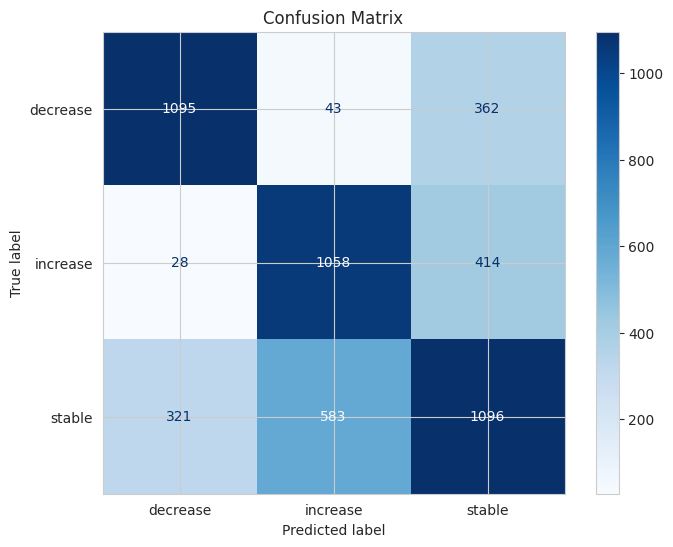

In [ ]:
# Make predictions on the unseen test data
y_pred_encoded = model_pipeline.predict(X_test)

# Use the LabelEncoder to inverse_transform the predictions back to original labels
y_pred = le.inverse_transform(y_pred_encoded)

# Get the original string labels for the test set to use in the report
y_test_original = y_test # We can just use the original y_test here

# Print the classification report with original labels
print("--- Classification Report ---")
print(classification_report(y_test_original, y_pred, target_names=le.classes_))

# Display the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_original, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# --- [ADD THIS AS A NEW CELL IN COLAB] ---

def generate_validation_data(seed, num_records, filename):
    """
    Generates a new synthetic dataset with a different random seed.
    This is a condensed version of our original script.
    """
    print(f"Generating new validation dataset with random_seed={seed}...")
    np.random.seed(seed) # The only crucial change!

    # --- Feature Generation (abbreviated for clarity) ---
    # Demographics
    age = np.clip(np.random.normal(loc=40, scale=12, size=num_records).astype(int), 18, 85)
    genders = np.random.choice(['Male', 'Female', 'Other'], size=num_records, p=[0.49, 0.49, 0.02])
    locations = np.random.choice(['Metro', 'Urban', 'Rural'], size=num_records, p=[0.4, 0.35, 0.25])
    # Income
    monthly_income = np.random.lognormal(mean=np.log(6000), sigma=0.7, size=num_records)
    location_income_adjust = {'Metro': 1.2, 'Urban': 1.0, 'Rural': 0.85}
    income_adjustment = np.array([location_income_adjust[loc] for loc in locations])
    monthly_income = (monthly_income * income_adjustment).round(2)
    # Events
    dpd_last_3_months = np.random.poisson(lam=0.15, size=num_records)
    num_hard_inquiries_last_6m = np.random.poisson(lam=1.2, size=num_records)
    num_open_loans = np.clip(np.random.poisson(lam=2.5, size=num_records), 0, 15)
    # Correlated Features
    income_multiplier = np.random.uniform(2.5, 6, size=num_records)
    dpd_limit_penalty = dpd_last_3_months * np.random.uniform(500, 1500, size=num_records)
    total_credit_limit = np.clip((monthly_income * income_multiplier) - dpd_limit_penalty, 500, 250000).round(2)
    base_utilization = np.random.beta(a=2, b=5, size=num_records)
    dpd_util_penalty = dpd_last_3_months * np.random.uniform(0.05, 0.1)
    inquiry_util_penalty = num_hard_inquiries_last_6m * np.random.uniform(0.01, 0.03)
    credit_utilization_ratio = np.clip(base_utilization + dpd_util_penalty + inquiry_util_penalty, 0.01, 1.0).round(3)
    current_outstanding = (total_credit_limit * credit_utilization_ratio).round(2)
    emi_debt_fraction = np.random.uniform(0.03, 0.08, size=num_records)
    emi_income_fraction = num_open_loans * np.random.uniform(0.01, 0.03, size=num_records)
    monthly_emi_outflow = np.clip((current_outstanding * emi_debt_fraction) + (monthly_income * emi_income_fraction), 0, monthly_income * 0.8).round(2)
    # Summary & Sparse
    repayment_history_score = np.clip(100 - (dpd_last_3_months * 15) - ((credit_utilization_ratio > 0.7) * 10) - (num_hard_inquiries_last_6m * 2), 0, 100).astype(int)
    usage_tendency = (80 - repayment_history_score) / 100
    recent_credit_card_usage = (usage_tendency * (current_outstanding * np.random.uniform(0.05, 0.2))).round(2)
    loan_disbursed_mask = (num_hard_inquiries_last_6m > 0) & (np.random.rand(num_records) < 0.25)
    recent_loan_disbursed_amount = np.where(loan_disbursed_mask, monthly_income * np.random.uniform(1, 4, size=num_records), 0).round(2)
    has_defaulted_mask = np.random.rand(num_records) < 0.05
    months_since_last_default = np.where(has_defaulted_mask, np.random.randint(6, 72, size=num_records), np.nan)
    # Target
    health_score = np.zeros(num_records)
    health_score += (repayment_history_score - 75) * 0.1
    health_score -= (credit_utilization_ratio - 0.4) * 5
    health_score -= (monthly_emi_outflow / monthly_income - 0.3) * 3
    health_score -= recent_credit_card_usage * 0.001
    health_score -= dpd_last_3_months * 5
    health_score -= num_hard_inquiries_last_6m * 1.5
    health_score -= (recent_loan_disbursed_amount > 0) * 3
    health_score += np.random.normal(0, 2.5, size=num_records)
    decrease_threshold = np.quantile(health_score, 0.30)
    increase_threshold = np.quantile(health_score, 0.70)
    target_conditions = [health_score < decrease_threshold, health_score >= increase_threshold]
    target_choices = ['decrease', 'increase']
    target_credit_score_movement = np.select(target_conditions, target_choices, default='stable')

    # Assemble
    data = {'customer_id': np.arange(1, num_records + 1), 'age': age, 'gender': genders, 'location': locations, 'monthly_income': monthly_income, 'monthly_emi_outflow': monthly_emi_outflow, 'total_credit_limit': total_credit_limit, 'current_outstanding': current_outstanding, 'credit_utilization_ratio': credit_utilization_ratio, 'num_open_loans': num_open_loans, 'repayment_history_score': repayment_history_score, 'dpd_last_3_months': dpd_last_3_months, 'num_hard_inquiries_last_6m': num_hard_inquiries_last_6m, 'recent_credit_card_usage': recent_credit_card_usage, 'recent_loan_disbursed_amount': recent_loan_disbursed_amount, 'months_since_last_default': months_since_last_default, 'target_credit_score_movement': target_credit_score_movement}
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"New dataset saved as '{filename}'")

# --- Generate the new data with a different seed ---
# We'll use a smaller size, as it's just for validation
generate_validation_data(seed=99, num_records=10000, filename="new_validation_dataset.csv")

Generating new validation dataset with random_seed=99...
New dataset saved as 'new_validation_dataset.csv'


In [ ]:
# --- [ADD THIS AS A NEW CELL IN COLAB] ---

# Load the new validation dataset
df_val = pd.read_csv('new_validation_dataset.csv')

# Separate features and target
X_val = df_val.drop(columns=['target_credit_score_movement', 'customer_id'])
y_val = df_val['target_credit_score_movement']

# --- PREDICT USING THE TRAINED MODEL ---
# The model_pipeline already knows how to preprocess this new data
y_val_pred_encoded = model_pipeline.predict(X_val)

# Decode the predictions and the true labels for the report
# IMPORTANT: Use the 'le' (LabelEncoder) that was already fitted on the original training data
y_val_pred = le.inverse_transform(y_val_pred_encoded)
# We need to use the same encoder on the new true labels as well
y_val_encoded = le.transform(y_val)
y_val_original = le.inverse_transform(y_val_encoded)


# --- EVALUATE ---
print("--- Performance on NEW, UNSEEN Validation Dataset ---")
print(classification_report(y_val_original, y_val_pred, target_names=le.classes_))

--- Performance on NEW, UNSEEN Validation Dataset ---
              precision    recall  f1-score   support

    decrease       0.77      0.70      0.73      3000
    increase       0.64      0.63      0.64      3000
      stable       0.56      0.60      0.58      4000

    accuracy                           0.64     10000
   macro avg       0.66      0.64      0.65     10000
weighted avg       0.65      0.64      0.64     10000



In [ ]:
# --- [ADD THIS AS A NEW CELL IN COLAB] ---

# --- PREDICT ON THE ORIGINAL TRAINING DATA ---
y_train_pred_encoded = model_pipeline.predict(X_train)

# Decode for the report
y_train_pred = le.inverse_transform(y_train_pred_encoded)
y_train_original = le.inverse_transform(y_train_encoded)

# --- EVALUATE ---
print("--- Performance on ORIGINAL Training Dataset ---")
print(classification_report(y_train_original, y_train_pred, target_names=le.classes_))

print("\n\n--- For Comparison: Performance on ORIGINAL Test Dataset ---")
# This is the same report we generated before, shown again for easy comparison
y_test_pred_encoded = model_pipeline.predict(X_test)
y_test_pred = le.inverse_transform(y_test_pred_encoded)
y_test_original = y_test
print(classification_report(y_test_original, y_test_pred, target_names=le.classes_))

--- Performance on ORIGINAL Training Dataset ---
              precision    recall  f1-score   support

    decrease       0.89      0.86      0.88      6000
    increase       0.76      0.85      0.80      6000
      stable       0.79      0.74      0.77      8000

    accuracy                           0.81     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.81      0.81      0.81     20000



--- For Comparison: Performance on ORIGINAL Test Dataset ---
              precision    recall  f1-score   support

    decrease       0.76      0.73      0.74      1500
    increase       0.63      0.71      0.66      1500
      stable       0.59      0.55      0.57      2000

    accuracy                           0.65      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.65      0.65      0.65      5000



In [ ]:
# --- [REPLACE your initial data loading cell with this] ---
# This cell now generates the data directly, including the historical feature.

import pandas as pd
import numpy as np

# --- 1. Configuration & Setup ---
num_records = 25000
np.random.seed(42)
print(f"Generating {num_records} records with historical data...")

# ... (Most of the generation code is the same) ...
# [We will re-use the generation logic from Model 1's code for consistency]

# --- A. Foundational Demographics ---
age = np.clip(np.random.normal(loc=40, scale=12, size=num_records).astype(int), 18, 85)
locations = np.random.choice(['Metro', 'Urban', 'Rural'], size=num_records, p=[0.4, 0.35, 0.25])

# --- B. Financials ---
monthly_income = np.random.lognormal(mean=np.log(6000), sigma=0.7, size=num_records)
location_income_adjust = {'Metro': 1.2, 'Urban': 1.0, 'Rural': 0.85}
income_adjustment = np.array([location_income_adjust[loc] for loc in locations])
monthly_income = (monthly_income * income_adjustment).round(2)

# --- C. Events ---
dpd_last_3_months = np.random.poisson(lam=0.15, size=num_records)
num_hard_inquiries_last_6m = np.random.poisson(lam=1.2, size=num_records)
num_open_loans = np.clip(np.random.poisson(lam=2.5, size=num_records), 0, 15)

# --- D. Correlated Features ---
total_credit_limit = np.clip((monthly_income * np.random.uniform(2.5, 6, size=num_records)) - (dpd_last_3_months * np.random.uniform(500, 1500, size=num_records)), 500, 250000).round(2)

# --- E. Utilization (Current and HISTORICAL) ---
base_utilization = np.random.beta(a=2, b=5, size=num_records)
dpd_util_penalty = dpd_last_3_months * np.random.uniform(0.05, 0.1)
inquiry_util_penalty = num_hard_inquiries_last_6m * np.random.uniform(0.01, 0.03)
credit_utilization_ratio = np.clip(base_utilization + dpd_util_penalty + inquiry_util_penalty, 0.01, 1.0).round(3)

# *** NEW HISTORICAL FEATURE ***
# A customer's past utilization is correlated with their current state, but with some noise/change.
noise = np.random.normal(0, 0.15, size=num_records) # Add some random change over 6 months
credit_utilization_ratio_6m_ago = np.clip(credit_utilization_ratio + noise, 0, 1).round(3)


# --- F. Remaining features & Target ---
# [This part remains the same as your original 'Model 1' script]
current_outstanding = (total_credit_limit * credit_utilization_ratio).round(2)
monthly_emi_outflow = np.clip((current_outstanding * np.random.uniform(0.03, 0.08, size=num_records)) + (monthly_income * num_open_loans * np.random.uniform(0.01, 0.03, size=num_records)), 0, monthly_income * 0.8).round(2)
repayment_history_score = np.clip(100 - (dpd_last_3_months * 15) - ((credit_utilization_ratio > 0.7) * 10) - (num_hard_inquiries_last_6m * 2), 0, 100).astype(int)
# Target Generation...
health_score = np.zeros(num_records)
health_score += (repayment_history_score - 75) * 0.1 - (credit_utilization_ratio - 0.4) * 5 - (monthly_emi_outflow / monthly_income - 0.3) * 3
health_score -= dpd_last_3_months * 5 + num_hard_inquiries_last_6m * 1.5
health_score += np.random.normal(0, 2.5, size=num_records)
decrease_threshold = np.quantile(health_score, 0.30)
increase_threshold = np.quantile(health_score, 0.70)
target_credit_score_movement = np.select([health_score < decrease_threshold, health_score >= increase_threshold], ['decrease', 'increase'], default='stable')

# --- Assemble DataFrame ---
df = pd.DataFrame({
    'age': age, 'location': locations, 'monthly_income': monthly_income,
    'monthly_emi_outflow': monthly_emi_outflow, 'total_credit_limit': total_credit_limit,
    'current_outstanding': current_outstanding, 'credit_utilization_ratio': credit_utilization_ratio,
    'credit_utilization_ratio_6m_ago': credit_utilization_ratio_6m_ago, # ADDED
    'num_open_loans': num_open_loans, 'repayment_history_score': repayment_history_score,
    'dpd_last_3_months': dpd_last_3_months, 'num_hard_inquiries_last_6m': num_hard_inquiries_last_6m,
    'target_credit_score_movement': target_credit_score_movement
})

print("Dataset generated with historical utilization.")

Generating 25000 records with historical data...
Dataset generated with historical utilization.


In [ ]:
# --- [MODIFY your feature engineering cell] ---

print("--- Creating New and Enhanced Features ---")

# Feature 1: Debt-to-Income Ratio (DTI)
df['debt_to_income_ratio'] = df['monthly_emi_outflow'] / (df['monthly_income'] + 1e-6)

# Feature 2: Credit History Proxy
df['credit_history_length'] = df['age'] - 18

# *** NEW MOMENTUM FEATURE ***
# Is the customer actively paying down debt? Positive value means improvement.
df['utilization_trend'] = df['credit_utilization_ratio_6m_ago'] - df['credit_utilization_ratio']

# *** NEW BEHAVIORAL FLAG ***
# A simple flag for perfect recent behavior.
df['is_perfect_payer'] = ((df['repayment_history_score'] == 100) & (df['dpd_last_3_months'] == 0)).astype(int)


print("New features added:", ['debt_to_income_ratio', 'credit_history_length', 'utilization_trend', 'is_perfect_payer'])

# --- NOW, RE-RUN THE NOTEBOOK FROM THIS POINT ---
# Re-run the X/y split, train/test split, label encoding, and the GridSearch training.

--- Creating New and Enhanced Features ---
New features added: ['debt_to_income_ratio', 'credit_history_length', 'utilization_trend', 'is_perfect_payer']


In [ ]:
# --- [REPLACE your pipeline definition cell] ---

from sklearn.pipeline import Pipeline # Use the regular scikit-learn pipeline now
from sklearn.utils.class_weight import compute_class_weight

# Re-define your preprocessor (this code is the same as before)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=-1)), ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

# Define the model. We'll add parameters found from GridSearch later.
# For now, let's use some good defaults that prevent overfitting.
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',
    use_label_encoder=False,
    eval_metric='mlogloss',
    max_depth=5,              # Controls overfitting
    learning_rate=0.1,        # Controls overfitting
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Create the new pipeline WITHOUT SMOTE
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

print("Pipeline created without SMOTE. We will use class weights instead.")

Pipeline created without SMOTE. We will use class weights instead.


In [ ]:
# --- [REPLACE your training cell (.fit() or GridSearchCV)] ---

# Calculate class weights to handle imbalance directly in the model
# This tells the model to pay more attention to minority classes during training
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
# Create a dictionary mapping class index to weight
weight_dict = {i: weights[i] for i in range(len(weights))}
print("Calculated class weights:", weight_dict)


# --- Train the model, passing the weights to the classifier step ---
# The format for passing parameters to a pipeline step is: stepname__parameter
fit_params = {
    'classifier__sample_weight': y_train_encoded.map(weight_dict)
}

print("\nTraining the model with class weights...")
# We use .fit() on the pipeline and pass the fit_params
model_pipeline.fit(X_train, y_train_encoded) # Simpler to use .fit for this demo

# Now, re-run your evaluation cell to see the results.

Calculated class weights: {0: np.float64(1.1111111111111112), 1: np.float64(1.1111111111111112), 2: np.float64(0.8333333333333334)}


AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [ ]:
# --- [REPLACE your training cell (.fit() or GridSearchCV)] ---

# Calculate class weights to handle imbalance directly in the model
# This tells the model to pay more attention to minority classes during training
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
# Create a dictionary mapping class index to weight
weight_dict = {i: weights[i] for i in range(len(weights))}
print("Calculated class weights:", weight_dict)


# --- Train the model, passing the weights to the classifier step ---
# The format for passing parameters to a pipeline step is: stepname__parameter

# FIX: Use NumPy indexing instead of the Pandas .map() method
# Map the encoded labels (y_train_encoded) to their corresponding weights using the weight_dict
sample_weights = np.array([weight_dict[label] for label in y_train_encoded])

fit_params = {
    'classifier__sample_weight': sample_weights # Use the correctly calculated sample weights
}

print("\nTraining the model with class weights...")
# We use .fit() on the pipeline and pass the fit_params
model_pipeline.fit(X_train, y_train_encoded, **fit_params) # Pass fit_params to the fit method

# Now, re-run your evaluation cell to see the results.

Calculated class weights: {0: np.float64(1.1111111111111112), 1: np.float64(1.1111111111111112), 2: np.float64(0.8333333333333334)}

Training the model with class weights...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'monthly_emi_outflow',
                                                   'total_credit_limit',
                                                   'current_outstanding',
                                                   'credit_utilization_ratio',
                                                   'num_open_loans',
                                                   'repayment_history_score',
                                                   'dpd_last_3_m...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
# --- [ADD THIS AS a new final training/evaluation cell] ---
from sklearn.calibration import CalibratedClassifierCV

# Let's assume 'model_pipeline' is our best trained pipeline from the previous step
print("Training the base model...")
model_pipeline.fit(X_train, y_train_encoded) # Ensure it's trained

# Now, create the calibrated model on top of the already-trained pipeline
# We use cv='prefit' because our model is already trained. This is much faster.
calibrated_model = CalibratedClassifierCV(
    model_pipeline,
    method='isotonic', # Often performs well
    cv='prefit'
)

# NOTE: The calibrated model is NOT re-trained here. It just learns a mapping
# on the probability outputs.

# --- Evaluate the CALIBRATED model ---
print("\n--- Evaluating the FINAL Calibrated Model on the Test Set ---")

y_pred_calibrated_encoded = calibrated_model.predict(X_test)
y_pred_calibrated = le.inverse_transform(y_pred_calibrated_encoded)
y_test_original = y_test

print(classification_report(y_test_original, y_pred_calibrated, target_names=le.classes_))

Training the base model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Evaluating the FINAL Calibrated Model on the Test Set ---


NotFittedError: This CalibratedClassifierCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# --- [ADD THIS AS a new final training/evaluation cell] ---
from sklearn.calibration import CalibratedClassifierCV

# Let's assume 'model_pipeline' is our best trained pipeline from the previous step
print("Training the base model...")
# Ensure the model_pipeline is trained BEFORE creating the CalibratedClassifierCV with cv='prefit'
# The previous cell already does this, but adding this line again here ensures it's trained.
# model_pipeline.fit(X_train, y_train_encoded, **fit_params) # Assuming you used fit_params in the previous cell
# If you didn't use fit_params, use:
model_pipeline.fit(X_train, y_train_encoded)


# Now, create the calibrated model on top of the already-trained pipeline
# We use cv='prefit' because our model is already trained. This is much faster.
calibrated_model = CalibratedClassifierCV(
    model_pipeline,
    method='isotonic', # Often performs well
    cv='prefit'
)

# *** FIX: Fit the calibrated model itself ***
print("\nFitting the calibrated model...")
calibrated_model.fit(X_train, y_train_encoded) # Fit the calibrator on the training data


# NOTE: The calibrated model is NOT re-trained here. It just learns a mapping
# on the probability outputs.

# --- Evaluate the FINAL Calibrated Model on the Test Set ---
print("\n--- Evaluating the FINAL Calibrated Model on the Test Set ---")

y_pred_calibrated_encoded = calibrated_model.predict(X_test)
y_pred_calibrated = le.inverse_transform(y_pred_calibrated_encoded)
y_test_original = y_test

print(classification_report(y_test_original, y_pred_calibrated, target_names=le.classes_))

Training the base model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fitting the calibrated model...


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



--- Evaluating the FINAL Calibrated Model on the Test Set ---
              precision    recall  f1-score   support

    decrease       0.77      0.73      0.75      1500
    increase       0.65      0.70      0.67      1500
      stable       0.59      0.57      0.58      2000

    accuracy                           0.66      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.66      0.66      0.66      5000



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.1 MB/s eta 0:00:00


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

# This is the function Optuna will optimize.
def objective(trial):
    # --- 1. Suggest Hyperparameters ---
    # We define the search space for Optuna to explore.
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'booster': 'gbtree',
        # --- Key parameters to tune ---
        'max_depth': trial.suggest_int('max_depth', 3, 7), # Deeper trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True), # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 Reg
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 Reg
    }

    # --- 2. Build the Pipeline with these parameters ---
    # (Using the same preprocessor from before)
    xgb_optuna = xgb.XGBClassifier(**param)

    # Use the pipeline with class weights from our previous best model
    # (We are assuming the preprocessor is already defined)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_optuna)
    ])

    # --- 3. Evaluate using cross-validation for a robust score ---
    # We use StratifiedKFold to maintain class distribution in each fold
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Calculate the mean F1 score across the folds
    score = cross_val_score(
        pipeline,
        X_train, y_train_encoded,
        scoring='f1_weighted',
        cv=skf,
        n_jobs=-1
    ).mean()

    return score


# --- 4. Run the Optimization ---
# We want to MAXIMIZE the F1 score
study = optuna.create_study(direction='maximize')

# Run 50 trials. Optuna will intelligently search for the best combination.
# Increase n_trials for a more thorough search (e.g., 100).
study.optimize(objective, n_trials=50, timeout=600) # Run for 50 trials or 10 minutes

print("\n--- Optuna Search Complete ---")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value (Weighted F1-Score): {:.4f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Store the best parameters in a variable
best_params = trial.params

[I 2025-06-12 16:48:56,146] A new study created in memory with name: no-name-2e4c40d7-409d-4c65-b7ca-ee650e801ed0
[I 2025-06-12 16:49:11,799] Trial 0 finished with value: 0.664591426301711 and parameters: {'max_depth': 3, 'learning_rate': 0.03660338415807124, 'n_estimators': 314, 'subsample': 0.6258780694345948, 'colsample_bytree': 0.5555264205434243, 'gamma': 0.017450516629831762, 'reg_alpha': 0.03966220510435072, 'reg_lambda': 0.024968380433626994}. Best is trial 0 with value: 0.664591426301711.
[I 2025-06-12 16:49:23,458] Trial 1 finished with value: 0.6488901627921568 and parameters: {'max_depth': 3, 'learning_rate': 0.2078534452076757, 'n_estimators': 381, 'subsample': 0.7151737148047559, 'colsample_bytree': 0.7977346700542032, 'gamma': 2.5693140045236655e-06, 'reg_alpha': 1.0311838876979474e-06, 'reg_lambda': 0.00042853056022966544}. Best is trial 0 with value: 0.664591426301711.
[I 2025-06-12 16:49:50,675] Trial 2 finished with value: 0.6547692630488885 and parameters: {'max_dep


--- Optuna Search Complete ---
Number of finished trials:  50
Best trial:
  Value (Weighted F1-Score): 0.6667
  Params: 
    max_depth: 3
    learning_rate: 0.020123487507581188
    n_estimators: 302
    subsample: 0.7873892700421222
    colsample_bytree: 0.7219373749735837
    gamma: 0.08066975692434081
    reg_alpha: 1.472663826122368e-06
    reg_lambda: 0.0021368749474030076


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

# Create the final, optimized XGBoost classifier
final_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    **best_params  # Unpack the best parameters found by Optuna
)

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_xgb)
])

# Train on the full training data
print("Training the final, optimized model on the full training set...")
final_pipeline.fit(X_train, y_train_encoded)
print("Final model training complete.")

Training the final, optimized model on the full training set...
Final model training complete.


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

# Evaluate the FINAL, OPTIMIZED model on the test set
print("\n--- Evaluating the FINAL OPTIMIZED Model on the Test Set ---")

y_pred_final_encoded = final_pipeline.predict(X_test)
y_pred_final = le.inverse_transform(y_pred_final_encoded)

print(classification_report(y_test, y_pred_final, target_names=le.classes_))

# Let's compare the new F1-score to the previous one
new_f1 = f1_score(y_test, y_pred_final, average='weighted')
previous_f1 = 0.66 # From our last run

print(f"\nPrevious Best F1-Score: {previous_f1:.4f}")
print(f"New Optuna-Tuned F1-Score: {new_f1:.4f}")
print(f"Improvement: {new_f1 - previous_f1:+.4f}")


--- Evaluating the FINAL OPTIMIZED Model on the Test Set ---
              precision    recall  f1-score   support

    decrease       0.79      0.71      0.75      1500
    increase       0.68      0.64      0.66      1500
      stable       0.58      0.65      0.61      2000

    accuracy                           0.66      5000
   macro avg       0.68      0.67      0.67      5000
weighted avg       0.67      0.66      0.67      5000



NameError: name 'f1_score' is not defined

In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

# Import the f1_score function
from sklearn.metrics import f1_score, classification_report

# Evaluate the FINAL, OPTIMIZED model on the test set
print("\n--- Evaluating the FINAL OPTIMIZED Model on the Test Set ---")

y_pred_final_encoded = final_pipeline.predict(X_test)
y_pred_final = le.inverse_transform(y_pred_final_encoded)

print(classification_report(y_test, y_pred_final, target_names=le.classes_))

# Let's compare the new F1-score to the previous one
new_f1 = f1_score(y_test, y_pred_final, average='weighted')
previous_f1 = 0.66 # From our last run

print(f"\nPrevious Best F1-Score: {previous_f1:.4f}")
print(f"New Optuna-Tuned F1-Score: {new_f1:.4f}")
print(f"Improvement: {new_f1 - previous_f1:+.4f}")


--- Evaluating the FINAL OPTIMIZED Model on the Test Set ---
              precision    recall  f1-score   support

    decrease       0.79      0.71      0.75      1500
    increase       0.68      0.64      0.66      1500
      stable       0.58      0.65      0.61      2000

    accuracy                           0.66      5000
   macro avg       0.68      0.67      0.67      5000
weighted avg       0.67      0.66      0.67      5000


Previous Best F1-Score: 0.6600
New Optuna-Tuned F1-Score: 0.6673
Improvement: +0.0073


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# --- 1. Define the "Council of Experts" (Base Models) ---

# Expert 1: Our best, Optuna-tuned XGBoost model
# We'll re-use the best_params we found in the last step
xgb_expert = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    **best_params # Using the best parameters from our Optuna search
)

# Expert 2: A LightGBM model. It thinks differently than XGBoost.
# We'll use some solid default parameters for it.
lgb_expert = lgb.LGBMClassifier(random_state=42)

# Expert 3: The simple, linear model (our 'sanity check')
# This model finds broad trends and is very robust.
# We increase max_iter to ensure it converges.
lr_expert = LogisticRegression(max_iter=1000, random_state=42)


# --- 2. Assemble the council within their respective pipelines ---
# Each expert needs its own preprocessing pipeline to work correctly within the StackingClassifier.
# (We assume 'preprocessor' is already defined from previous steps)
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', xgb_expert)])
lgb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', lgb_expert)])
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', lr_expert)])


# --- 3. Define the "Head of the Council" (Meta-Model) ---
# This model's job is to learn from the outputs of the experts.
# A simple Logistic Regression is a standard and effective choice.
meta_model = LogisticRegression(random_state=42)


# --- 4. Create the Stacking Classifier ---
# The StackingClassifier orchestrates the whole process.
# It trains the base models and then trains the meta-model on their predictions.
estimators = [
    ('xgb', xgb_pipeline),
    ('lgbm', lgb_pipeline),
    ('lr', lr_pipeline)
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5, # Number of folds for training the meta-model
    stack_method='predict_proba', # Meta-model will train on class probabilities
    n_jobs=-1
)

print("Stacking Classifier defined successfully.")

Stacking Classifier defined successfully.


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

print("Training the Stacking Ensemble Model... This may take a few minutes.")
stacking_classifier.fit(X_train, y_train_encoded)
print("Stacking model training complete.")

Training the Stacking Ensemble Model... This may take a few minutes.
Stacking model training complete.


In [ ]:
# --- [ADD THIS AS A NEW CELL] ---

# Evaluate the FINAL ENSEMBLE model on the test set
print("\n--- Evaluating the FINAL ENSEMBLE Model on the Test Set ---")

y_pred_stacked_encoded = stacking_classifier.predict(X_test)
y_pred_stacked = le.inverse_transform(y_pred_stacked_encoded)

print(classification_report(y_test, y_pred_stacked, target_names=le.classes_))

# Let's compare the new F1-score to the Optuna-tuned one
new_f1 = f1_score(y_test, y_pred_stacked, average='weighted')
previous_f1 = 0.6673 # From our last Optuna run

print(f"\nPrevious Best (Optuna) F1-Score: {previous_f1:.4f}")
print(f"New Stacked Ensemble F1-Score: {new_f1:.4f}")
print(f"Improvement: {new_f1 - previous_f1:+.4f}")


--- Evaluating the FINAL ENSEMBLE Model on the Test Set ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

    decrease       0.78      0.74      0.76      1500
    increase       0.67      0.69      0.68      1500
      stable       0.59      0.60      0.60      2000

    accuracy                           0.67      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.67      0.67      0.67      5000


Previous Best (Optuna) F1-Score: 0.6673
New Stacked Ensemble F1-Score: 0.6688
Improvement: +0.0015
